### Method to estimate the bias probability density and the force component related to the probability density. Typically contain set of 10 to 20 x-y position data.

#### First, define constants, base functions and load positions.

In [3]:
import numpy as np
import os
import time
import glob
import matplotlib.pyplot as plt
from numba import jit, njit
from matplotlib import ticker

In [4]:
#Define grid 
min_grid = -np.pi
max_grid = np.pi
nbins = 200
x = np.linspace(min_grid, max_grid, nbins)
grid_space = (max_grid - min_grid) / (nbins-1)
#Define constants
bw = 0.1
bw2 = bw**2
stride = 10
const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
kT = 2.49
x0, y0 = 0,0

In [5]:
def load_HILLS(hills_name="HILLS"):
    """Load 1-dimensional hills data (includes time, position_x, position_y, hills_parameters 

    Args:
        hills_name (str, optional): Name of hills file. Defaults to "HILLS".

    Returns:
        np.array: Array with hills data
    """
    for file in glob.glob(hills_name):
        hills = np.loadtxt(file)
        hills = hills[:-1]
        hills0 = np.array(hills[0])
        hills0[3] = 0
        hills = np.concatenate(([hills0], hills))
    return hills

def load_position(position_name="position"):
    """Load 1-dimensional position/trajectory data.

    Args:
        position_name (str, optional): Name of position file. Defaults to "position".

    Returns:
        position (list):  np.array with position data
    """
    for file1 in glob.glob(position_name):
        colvar = np.loadtxt(file1)
    return colvar[:-1, 1]

def index(position, min_grid, grid_space):
    """Finds (approximate) index of a position in a grid. Independent of CV-type.

    Args:
        position (float): position of interest
        min_grid (float): minimum value of grid
        grid_space (float): grid spacing

    Returns:
        int: index of position
    """
    return int((position-min_grid)//grid_space) + 1

def find_periodic_point(x_coord, min_grid, max_grid, periodic):
    """Finds periodic copies of input coordinate. 

    Args:
        x_coord (float): CV-coordinate
        min_grid (float): minimum value of grid
        max_grid (float): maximum value of grid
        periodic (binary): information if system is periodic. value of 0 corresponds to non-periodic system; function will only return input coordinates. Value of 1 corresponds to periodic system; function will return input coordinates with periodic copies.


    Returns:
        list: list of input coord and possibly periodic copies
    """
    if periodic == 1:
        coord_list = []
        #There are potentially 2 points, 1 original and 1 periodic copy.
        coord_list.append(x_coord)
        #define grid extension
        grid_ext = 0.25 * (max_grid-min_grid)
        #check for copy
        if x_coord < min_grid+grid_ext: coord_list.append(x_coord + 2*np.pi)
        elif x_coord > max_grid-grid_ext: coord_list.append(x_coord - 2*np.pi)

        return coord_list
    else:
        return [x_coord]

In [6]:
HILLS = load_HILLS("../data/1D_wall_pot/HILLS")
position = load_position("../data/1D_wall_pot/position")

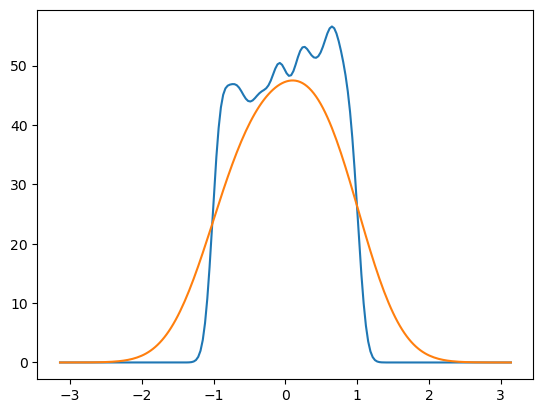

In [9]:
import random

bw = 0.1
bw2 = bw**2
stride = 10
const = (1 / (bw * np.sqrt(2 * np.pi) * stride))

bw_B = 0.5
bw2_B = bw_B**2
stride_B = 10
const_B = (1 / (bw_B * np.sqrt(2 * np.pi) * stride_B))


pb_t = np.zeros_like(x)
pb_t_B = np.zeros_like(x)

for j in range(1000):
    
    a = random.randint(0,200) / 100 - 1
    
    kernel = const * np.exp( - (1 / (2 * bw2)) * (x - a) ** 2)
    pb_t += kernel
    
    kernel_B = const_B * np.exp( - (1 / (2 * bw2_B)) * (x - a) ** 2)
    pb_t_B += kernel_B
    
    
plt.plot(x, pb_t, label=str(bw))
plt.plot(x, pb_t_B, label=str(bw_B))
plt.legend()
		


### (0) Naive method

In [12]:
#Number of evaluations
nhills = 10000
n_eval = int(nhills / (stride/10))
pos = position[:stride*n_eval]

In [8]:
def gaus_normal(data):
	
	pb_t = np.zeros_like(x)
	Fpbt = np.zeros_like(x)
	
	for j in range(len(data)):
		
		kernel = const * np.exp( - (1 / (2 * bw2)) * (x - data[j]) ** 2)
		pb_t = pb_t + kernel
		Fpbt = Fpbt + kernel * kT * (x - data[j]) / bw2
		
	return [pb_t, Fpbt]

In [76]:
#-->Run Gaus normal
results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_normal(pos[i*stride: (i+1)*stride]) 
[P, F] = results

t_normal = time.time()-start	
print("time for >>gaus_normal<< is:", t_normal)

time for >>gaus_normal<< is: 1.2489001750946045


Text(0.5, 1.0, 'FX normal')

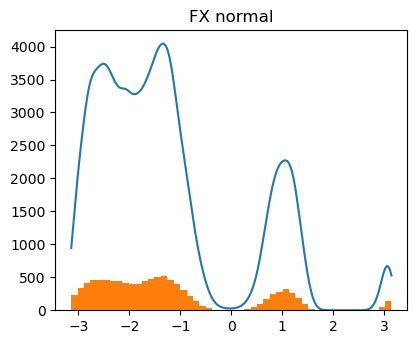

In [77]:
plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, P)
plt.hist(HILLS[:n_eval,1], bins=50)
plt.title("FX normal")

### (1) Numpy mothod (optimise the use of numpy)

In [78]:
def gaus_numpy(data):
	
	pb_t = np.zeros_like(x)
	Fpbt = np.zeros_like(x)
	
	for j in range(len(data)):
		
		kernel = const * np.exp( - np.square(x - data[j]) / (2 * bw2))
		pb_t += kernel
		Fpbt += kT / bw2 * np.multiply(kernel, (x - data[j]))
		
	return [pb_t, Fpbt]

time for >>gaus_numpy2<< is: 1.2332220077514648
time saving: 1.26 %
differecen in pb_t: 4.014518935108093e-14 
differecen in F: 7.972080114104774e-13


Text(0.5, 1.0, 'FX normal')

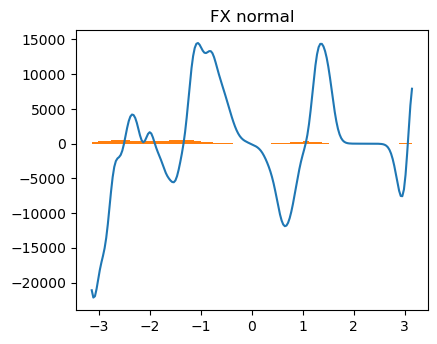

In [79]:
#-->Run Gaus Numpy2
results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_numpy(pos[i*stride: (i+1)*stride]) 
[Ps, Fs] = results

t_numpy = time.time()-start

print("time for >>gaus_numpy2<< is:", t_numpy)
print("time saving:", round(100*(t_normal - t_numpy)/t_normal, 2), "%")
print("differecen in pb_t:", sum(abs(P - Ps)) / nbins, "\ndifferecen in F:", sum(abs(F - Fs)) / nbins)

plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, Fs)
plt.hist(HILLS[:n_eval,1], bins=50)
plt.title("FX normal")

### (2) No-Loop method (uses vectorisation instead of for loops)

In [94]:
x10 = np.broadcast_to(x, (stride,)+x.shape)

def gaus_noloop(data):
	

	data = np.expand_dims(data, axis=1)
	print(x10.shape, data.size)
 
	print(type(x10), type(data))
	diff = x10 - data
			
	kernel = const * np.exp( - np.square(diff) / (2 * bw2))
	pb_t = np.sum(kernel, axis=0)

	Fpbt_kernel = kT / bw2 * np.multiply(kernel, diff)
	Fpbt = np.sum(Fpbt_kernel, axis=0)
		
	return [pb_t, Fpbt]

(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 200) 10
<class 'num

Text(0.5, 1.0, 'FX normal')

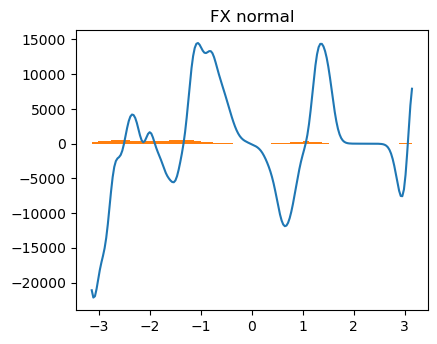

In [95]:
#-->Run Gaus NoLoop2
results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_noloop(pos[i*stride: (i+1)*stride]) 
[Ps, Fs] = results
t_noloop = time.time()-start

print("time for >>gaus_noloop<< is:", t_noloop)
print("time saving:", round(100*(t_normal - t_noloop)/t_normal, 2), "%")
print("differecen in pb_t:", sum(abs(P - Ps)) / nbins, "\ndifferecen in F:", sum(abs(F - Fs)) / nbins)

plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, Fs)
plt.hist(HILLS[:n_eval,1], bins=50)
plt.title("FX normal")


### (3) Gradient method (Calculates the force from the gradient of the sum of probability densities)

In [83]:
x10 = np.broadcast_to(x, (stride,)+x.shape)

def gaus_gradient(data):
	
	data = np.expand_dims(data, axis=1)
	diff = x10 - data
			
	kernel = const * np.exp( - np.square(diff) / (2 * bw2))
	pb_t = np.sum(kernel, axis=0)

	Fpbt = - np.gradient(pb_t, grid_space)
		
	return [pb_t, Fpbt]


time for >>gaus_gradient<< is: 0.6645810604095459
time saving: 46.79 %
differecen in pb_t: 4.014518935108093e-14 
differecen in F: 3206.8848247488077


Text(0.5, 1.0, 'FX normal')

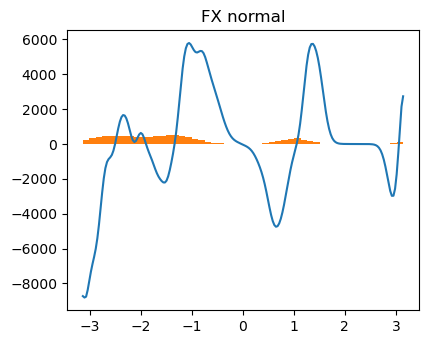

In [84]:
#-->Run Gaus Gradient
results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_gradient(pos[i*stride: (i+1)*stride]) 
[Ps, Fs] = results
t_gradient = time.time()-start

print("time for >>gaus_gradient<< is:", t_gradient)
print("time saving:", round(100*(t_normal - t_gradient)/t_normal, 2), "%")
print("differecen in pb_t:", sum(abs(P - Ps)) / nbins, "\ndifferecen in F:", sum(abs(F - Fs)) / nbins)

plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, Fs)
plt.hist(HILLS[:n_eval,1], bins=50)
plt.title("FX normal")

### (4) Numpy and @njit

In [85]:
@njit
def gaus_numba(data):

	
	pb_t = np.zeros_like(x)
	Fpbt = np.zeros_like(x)
	
	for j in range(len(data)):
		
		kernel = const * np.exp( - np.square(x - data[j]) / (2 * bw2))
		pb_t += kernel
		Fpbt += kT / bw2 * np.multiply(kernel, (x - data[j]))
		
	return [pb_t, Fpbt]


x10 = np.broadcast_to(x, (stride,)+x.shape)
@njit
def gaus_numba2(data):
	
	data = np.expand_dims(data, axis=1)
	diff = x10 - data
			
	kernel = const * np.exp( - np.square(diff) / (2 * bw2))
	pb_t = np.sum(kernel, axis=0)

	Fpbt_kernel = kT / bw2 * np.multiply(kernel, diff)
	Fpbt = np.sum(Fpbt_kernel, axis=0)
		
	return [pb_t, Fpbt]

time for >>gaus_numba<< is: 0.28652453422546387
time saving: 77.06 %
differecen in pb_t: 4.014518935108093e-14 
differecen in F: 7.972080114104774e-13


time for >>gaus_numba2<< is: 0.2629404067993164
time saving: 78.95 %
differecen in pb_t: 4.014518935108093e-14 
differecen in F: 7.972080114104774e-13


Text(0.5, 1.0, 'FX normal')

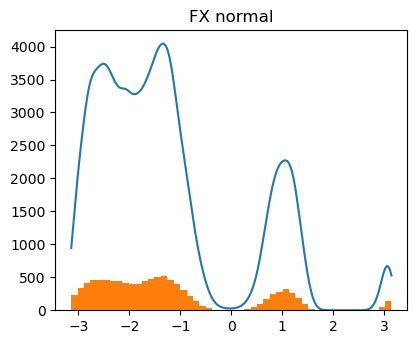

In [87]:
#-->Run Gaus Numba
results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_numba(pos[i*stride: (i+1)*stride]) 
[Ps, Fs] = results
t_numba = time.time()-start

print("time for >>gaus_numba<< is:", t_numba)
print("time saving:", round(100*(t_normal - t_numba)/t_normal, 2), "%")
print("differecen in pb_t:", sum(abs(P - Ps)) / nbins, "\ndifferecen in F:", sum(abs(F - Fs)) / nbins)


results = np.zeros((2,nbins))
start = time.time()
for i in range(n_eval): results += gaus_numba2(pos[i*stride: (i+1)*stride]) 
[Ps, Fs] = results
t_numba2 = time.time()-start

print("\n\ntime for >>gaus_numba2<< is:", t_numba2)
print("time saving:", round(100*(t_normal - t_numba2)/t_normal, 2), "%")
print("differecen in pb_t:", sum(abs(P - Ps)) / nbins, "\ndifferecen in F:", sum(abs(F - Fs)) / nbins)

plt.figure(1, figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, Ps)
plt.hist(HILLS[:n_eval,1], bins=50)
plt.title("FX normal")


### Pleas feel free to contribute with your own ideas!


### Plot differences

In [ ]:
# plt.figure(1, figsize=(10,8))
# plt.subplot(2,2,1)
# plt.contourf(X,Y,FX, cmap="coolwarm")#, levels = np.linspace(-80,80,11))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FX normal")

# plt.subplot(2,2,2)
# plt.contourf(X,Y,FXs, cmap="coolwarm")#, levels = np.linspace(-1,1,21))
# # plt.contourf(X,Y,abs(FX - FXs), cmap="coolwarm", levels = np.linspace(-1,1,21))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FX outer")

# # plt.figure(2, figsize=(10,4))
# plt.subplot(2,2,3)
# plt.contourf(X,Y,FY, cmap="coolwarm")
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FY normal")

# plt.subplot(2,2,4)
# plt.contourf(X,Y,FYs, cmap="coolwarm")#, levels = np.linspace(-1,1,21))
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)
# plt.title("FY outer")

# plt.figure(3, figsize=(10,4))
# plt.subplot(1,2,1)
# plt.contourf(X,Y,P, cmap="coolwarm")#, levels = np.linspace(0,7,51))
# plt.colorbar()
# plt.scatter(p_x[:n_eval*10], p_y[:n_eval*10], c="yellow", s=2)
# plt.title("P normal")

# plt.subplot(1,2,2)
# plt.contourf(X,Y,Ps, cmap="coolwarm")#, levels = np.linspace(0,7,51))
# plt.colorbar()
# plt.scatter(p_x[:n_eval*10], p_y[:n_eval*10], c="yellow", s=2)
# plt.title("Ps outer")

# plt.show()